In [1]:
from torch.distributions.beta import Beta
from mutect3 import tensors, train, networks, data
from mutect3 import normal_artifact as na
import torch.utils.data

%matplotlib inline

ImportError: cannot import name 'normal_artifact' from 'mutect3' (/Users/davidben/mutect3/mutect3/__init__.py)

In [ ]:
# load table files produced by GATK, parse and generate data, and pickle data
PICKLE_DIR = '/Users/davidben/mutect3/pickles/'
TABLE_DIR = '/Users/davidben/mutect3/tables/'
SAVED_MODEL_DIR = '/Users/davidben/mutect3/saved/'


DREAMS = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

DREAM_1_PAIR, DREAM_2_PAIR, DREAM_3_PAIR, DREAM_4_PAIR = (PICKLE_DIR + dream + '-pair-train.pickle' for dream in DREAMS)
DREAM_1_TEST, DREAM_2_TEST, DREAM_3_TEST, DREAM_4_TEST = (PICKLE_DIR + dream + '-test.pickle' for dream in DREAMS)

DREAM_1_NA, DREAM_2_NA, DREAM_3_NA, DREAM_4_NA = (PICKLE_DIR + dream + '-normal-artifact.pickle' for dream in DREAMS)
DREAM_1_SMALL_NA, DREAM_2_SMALL_NA, DREAM_3_SMALL_NA, DREAM_4_SMALL_NA = (PICKLE_DIR + dream + '-small-normal-artifact.pickle' for dream in DREAMS)

# just dream 1 for speed
#DREAMS = ['dream1']
#tumor_samples = ['synthetic.challenge.set1.tumor']
#normal_samples = ['synthetic.challenge.set1.normal']

DREAM_1_SMALL_PAIR = PICKLE_DIR + 'dream1-small-pair-train.pickle'
DREAM_1_SMALL_TEST = PICKLE_DIR + 'dream1-small-test.pickle'

#NA_TABLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.table'
#NA_PICKLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.pickle'

GENERATE_PICKLES = False
if GENERATE_PICKLES:
    for dream, tumor_sample, normal_sample in zip(DREAMS, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)
        tumor_table, normal_table = (TABLE_DIR + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        tensors.generate_pickles(tumor_table, normal_table, tumor_sample, normal_sample, PICKLE_DIR, dream)  
        
        na_table = TABLE_DIR + dream + '-small-normal-artifact.table'
        na_pickle = PICKLE_DIR + dream + '-small-normal-artifact.pickle'
        na.generate_normal_artifact_pickle(na_table, na_pickle)

Training normal artifact model


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Unlabeled data: 19577, labeled data: 18968
Dataset sizes -- training: 34690, validation: 3855


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

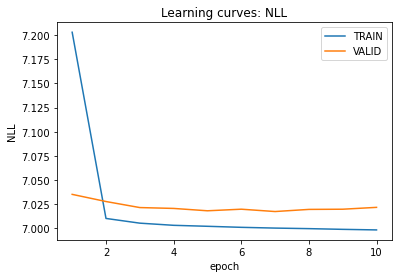

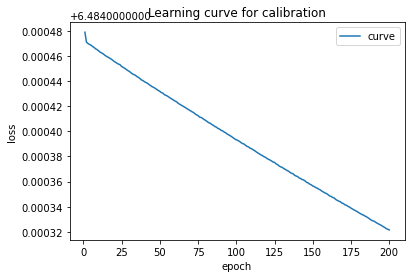

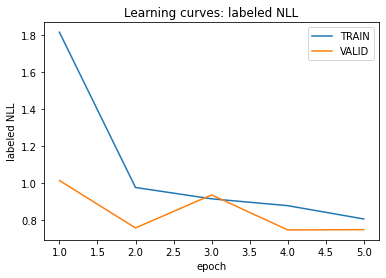

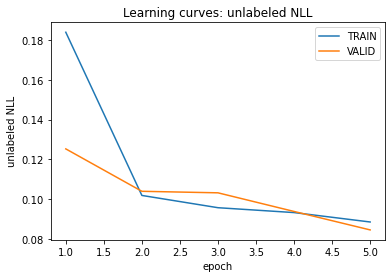

In [3]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 5
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [20,20]
hidden_info_layers = [20,20]
aggregation_layers = [20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)

#trained_model = train.run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, DREAM_1_SMALL_NA, params, m3_params)

saved_model_path = SAVED_MODEL_DIR + 'saved.pt'
model = train.make_trained_mutect3_model(m3_params, [DREAM_1_SMALL_PAIR], [DREAM_1_SMALL_NA], params)
train.save_mutect3_model(model, m3_params, saved_model_path)

AF spectra epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Optimal logit threshold: 0.07203666865825653


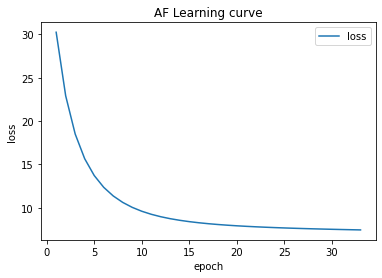

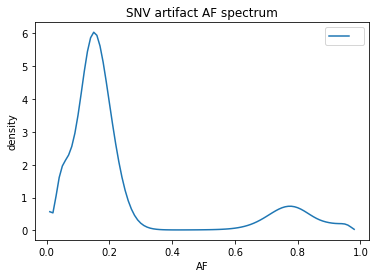

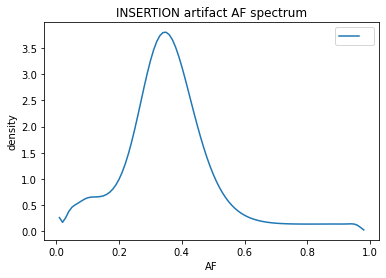

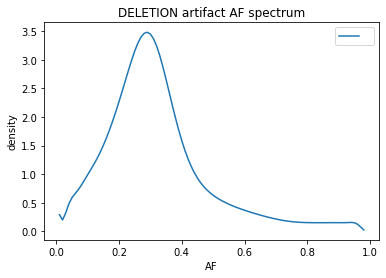

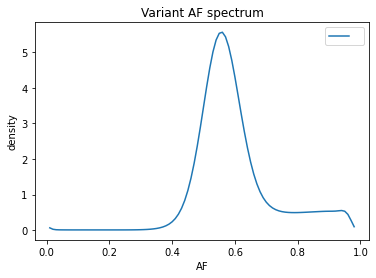

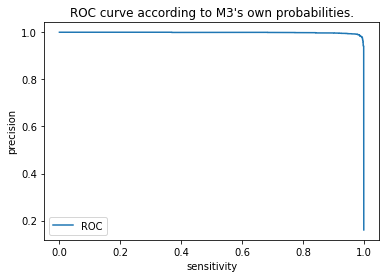

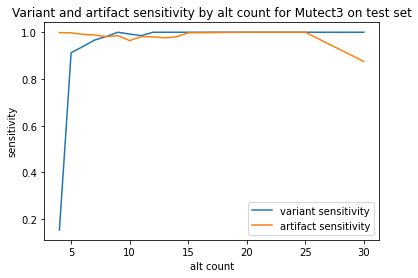

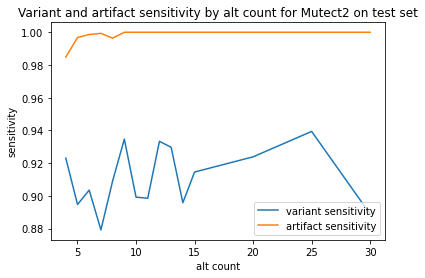

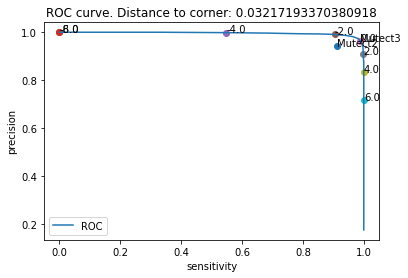

In [5]:
loaded_model = train.load_saved_model(saved_model_path)
train.run_evaluation(loaded_model, DREAM_1_TEST, params)

In [ ]:
training_pickles, test_pickle = [DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST
train, valid, test = data.make_datasets(training_pickles, test_pickle)

In [ ]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 20
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [30,30,30,30]
hidden_info_layers = [20,20,20]
aggregation_layers = [20,20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)
trained_model = train.run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, NA_PICKLE, params, m3_params)

In [ ]:
alpha, beta = na_model.get_beta_parameters(batch)
shapes = torch.stack((alpha, beta), dim=1)

In [ ]:
datum = na.NormalArtifactDatum(normal_alt_count=0, normal_depth=50, tumor_alt_count=10, tumor_depth=20, downsampling=1.0, variant_type="SNV")
na_model.plot_spectrum(datum, "PLOT")

In [ ]:
snv_normal_af = []
snv_tumor_af = []
indel_normal_af = []
indel_tumor_af = []
for datum in na_train:
    if datum.variant_type() == "SNV":
        snv_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        snv_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))
    else:
        indel_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        indel_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(torch.tensor(snv_normal_af), torch.tensor(snv_tumor_af), s=0.5,alpha=0.01)

In [ ]:
plt.scatter(torch.tensor(indel_normal_af), torch.tensor(indel_tumor_af), s=0.5,alpha=1.0)

In [7]:
import pysam

In [2]:
import pysam
from pysam import VariantFile

In [4]:
tumor, normal = 'synthetic.challenge.set1.tumor', 'synthetic.challenge.set1.normal'
ref_downsample = 20
NUM_READ_FEATURES = 11

vcf_in = VariantFile("/Users/davidben/mutect3/vcfs/dream1-expt.vcf") 
for rec in vcf_in:
    datum = tensors.unlabeled_datum_from_vcf(rec, tumor, normal, ref_downsample)
    print(datum)

    
    


In [22]:
tumor, normal = 'synthetic.challenge.set1.tumor', 'synthetic.challenge.set1.normal'

vcf_in = VariantFile("/Users/davidben/mutect3/vcfs/dream1-expt.vcf")  # auto-detect input format
#vcf_out = VariantFile('-', 'w', header=vcf_in.header)


# this takes a table from VariantsToTable and produces a Python list of Datum objects


(5, 26)
(40, 25, 0, 0, 0, 56, 293, -1, 294, 0, 0, 40, 25, 0, 0, 0, 94, 138, -1, 139, 0, 0, 53, 25, 0, 1, 0, 58, 380, 346, 34, 0, 0, 36, 25, 0, 1, 0, 53, 371, 340, 31, 1, 0, 60, 25, 0, 1, 0, 46, 370, 346, 24, 1, 0, 31, 25, 1, 0, 0, 54, 92, -1, 93, 0, 0, 40, 25, 1, 0, 0, 101, 121, -1, 122, 0, 0, 39, 25, 1, 0, 0, 101, 109, 4, 105, 1, 0, 40, 25, 1, 0, 0, 101, 121, -1, 122, 0, 0, 39, 25, 1, 1, 0, 101, 420, 332, 88, 0, 1, 37, 25, 1, 1, 0, 101, 424, 334, 90, 0, 0, 29, 25, 1, 1, 0, 97, 379, 293, 86, 1, 1, 21, 25, 0, 1, 0, 97, 430, 343, 87, 2, 0, 33, 25, 0, 0, 0, 90, 103, 2, 101, 0, 0, 21, 25, 1, 0, 0, 65, 64, -1, 65, 1, 0, 49, 25, 1, 1, 0, 45, 388, 346, 42, 1, 0, 40, 25, 1, 1, 0, 101, 436, 338, 98, 1, 1, 35, 25, 1, 0, 0, 91, 0, 9, -9, 0, 1, 60, 25, 0, 1, 0, 101, 121, 16, 105, 2, 0, 51, 25, 1, 0, 0, 100, 113, -1, 114, 1, 1, 21, 25, 1, 0, 0, 97, 0, -1, 1, 1, 0, 40, 25, 0, 1, 0, 101, 121, 12, 109, 1, 0, 46, 25, 1, 1, 0, 92, 423, 322, 101, 2, 0, 54, 25, 1, 1, 0, 101, 138, 28, 110, 0, 0, 53, 25, 1,

In [7]:
import torch
a = torch.tensor([1.0,2.0,3.0])
b = torch.tensor([4.0,5.0,6.0])

In [8]:
print(a,b)

tensor([1., 2., 3.]) tensor([4., 5., 6.])


In [11]:
c=torch.column_stack((a,b))
c

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

In [14]:
torch.logsumexp(c,dim=1)

tensor([4.0486, 5.0486, 6.0486])